# Part 1: Introduction

For our final project, we're delving into the factors influencing fraudulent transactions using a dataset containing credit card transaction details, including both fraudulent and non-fraudulent instances, from hundreds of buyers and stores. Our analysis focuses on several key input columns: transaction time, transaction category, transaction amount, credit card holder's information, merchant's geographic location, and whether the transaction is fraudulent or not. Ultimately, our goal is to better uncover anomalies indicative of fraudulent transactions with exploratory data analysis and machine learning techniques.

For our first step, we want to prepare for a suitable environment for our later data analysis and machine learning model building. We set our seed = 123 to mimic pseudo-random behavior, install pyspark which we will use later for machine learning, and import relevant libraries for all stages of this project, including data cleaning and preprocessing, exploratory data analysis, feature engineering, and modeling.

In [ ]:
# For producing reproducible results

seed = 123

In [ ]:
!pip install pyspark
!pip install pandas --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=fe163fa6be4c9fd28db5b0c6bb2393172f82ccf1b283dbe588c0cb72b11fe1e1
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 70.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


In [ ]:
# imports (add any you end up using here)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import datetime
from datetime import *
import pyspark

# Scikit-learn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix

# PySpark
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Part 2: Data Cleaning

Having downloaded the two raw datasets, `fraudTest.csv` and `fraudTrain.csv`, from Kaggle, we would like to conduct initial data cleaning for our later exploratory data analysis and modeling. This includes dropping irrelevant columns, changing data types for sub-feature extraction, and creating additional columns. We first load the two datasets.

In [ ]:
# Load in data for cleaning
drive.mount('/content/drive')
fraud_test = pd.read_csv("/content/drive/My Drive/fraudTest.csv")
fraud_train = pd.read_csv("/content/drive/My Drive/fraudTrain.csv")

Mounted at /content/drive


Even though the transaction data has been splitted into training and testing set, we decide to combine them for a more convenient and consistent data cleaning process. It also allows for increased flexibility to handle the full set of data.

In [ ]:
# Combine for cleaning

all_fraud = pd.concat([fraud_test, fraud_train])
all_fraud.reset_index(drop = True, inplace = True)

In [ ]:
# Rename columns appropriately

all_fraud.rename(columns = {"trans_date_trans_time": "transaction_datetime",
                           "cc_num": "card_number",
                           "merchant": "store",
                           "category": "purchase_type",
                           "amt": "purchase_amount",
                           "first": "buyer_first_name",
                           "last": "buyer_last_name",
                           "gender": "buyer_gender",
                           "city": "buyer_home_city",
                           "state": "buyer_home_state",
                           "zip": "buyer_home_zip",
                           "lat": "buyer_home_lat",
                           "long": "buyer_home_long",
                           "job": "buyer_job",
                            "dob": "buyer_birthday",
                            "trans_num": "transaction_number",
                            "merch_lat": "store_lat",
                            "merch_long": "store_long"
                           }, inplace=True)

We want to change the data types of the columns containing dates from `object` to `datatime64[ns]` for convenient extraction of different parts of dates.

In [ ]:
# Change columns datatypes

all_fraud = all_fraud.astype({"transaction_datetime": "datetime64[ns]",
                             "buyer_birthday": "datetime64[ns]"})

Due to the size a fraud proportion in the data, we decided to cut the data down from 1 million rows to about 50,000, and also resample so that we have a fraud proportion of 1/4.

In [ ]:
# Randomly sample 51000 rows (with replacement), with 1/4 being fraud and 3/4 being non-fraud.

all_fraud = pd.concat([all_fraud[all_fraud["is_fraud"] == 0].sample(n=38000, random_state=seed, replace = True),
                             all_fraud[all_fraud["is_fraud"] == 1].sample(n=13000, random_state=seed, replace = True)])
all_fraud.reset_index(drop = True, inplace = True)

For the purchase type column, as we have not figured out the meaning of `pos` and `net`, we group these categories together.


In [ ]:
# Group purchase type categories

for row in range(len(all_fraud)):
  if all_fraud["purchase_type"][row] in ["grocery_pos", "grocery_net", "shopping_pos", "shopping_net", "misc_pos", "misc_net"]:
    if all_fraud["purchase_type"][row] == "grocery_pos":
        all_fraud.loc[row, "purchase_type"] = "grocery"
    elif all_fraud["purchase_type"][row] == "grocery_net":
        all_fraud.loc[row, "purchase_type"] = "grocery"
    elif all_fraud["purchase_type"][row] == "shopping_pos":
        all_fraud.loc[row, "purchase_type"] = "shopping"
    elif all_fraud["purchase_type"][row] == "shopping_net":
        all_fraud.loc[row, "purchase_type"] = "shopping"
    elif all_fraud["purchase_type"][row] == "misc_pos":
        all_fraud.loc[row, "purchase_type"] = "misc"
    elif all_fraud["purchase_type"][row] == "misc_net":
        all_fraud.loc[row, "purchase_type"] = "misc"

In [ ]:
# Drop null rows

all_fraud = all_fraud.dropna().reset_index(drop = True)

Speculating that the buyer's age might be relevant to the fraud detection process, we decide to engineer an `age` column from the buyer's birthday and transaction time.

In [ ]:
# Create an age column

all_fraud["buyer_age"] = all_fraud["transaction_datetime"] - all_fraud["buyer_birthday"]
all_fraud["buyer_age"] = all_fraud["buyer_age"] / timedelta(minutes=1)
all_fraud["buyer_age"] = np.floor(all_fraud["buyer_age"] / 525600).astype("int")

Now, we move to dropping irrelevant columns which we think might not help detect fraudulent transactions. They include the buyer's name, buyer's home information, store's location, transaction number, and others that have too many unique values.

In [ ]:
# Drop unnecessary columns

all_fraud.drop(columns = ["street", "unix_time", "Unnamed: 0", 'store', 'buyer_first_name', 'buyer_last_name',
                          'buyer_home_city', 'buyer_home_state', 'buyer_home_zip', 'buyer_home_lat', 'buyer_home_long',
                          'buyer_job', 'buyer_birthday', 'transaction_number'], inplace = True)

In [ ]:
# Rearrange columns for easier navigating

all_fraud =  all_fraud[['transaction_datetime', 'purchase_type',
       'purchase_amount', 'buyer_gender', 'card_number', 'buyer_age', "store_long", 'store_lat', 'is_fraud']]

In [ ]:
# One more randomization to randonly distribute rows throughout the data frame

all_fraud = all_fraud.sample(n=51000, random_state=seed).reset_index(drop = True)

In [ ]:
all_fraud.head()

,transaction_datetime,purchase_type,purchase_amount,buyer_gender,card_number,buyer_age,store_long,store_lat,is_fraud
0,2019-06-02 12:02:15,food_dining,19.33,F,6528911529051375,54,-90.584866,46.627470,0
1,2019-04-02 17:26:36,home,39.96,F,4561368699336875,30,-80.878043,35.866491,0
2,2020-07-24 07:20:24,grocery,135.58,F,60490596305,57,-90.632878,34.316550,0
3,2020-08-30 23:26:50,shopping,8.05,M,4312133045694601139,43,-76.537518,38.601080,0
4,2020-07-16 20:40:10,kids_pets,12.93,F,4129767952109660,48,-95.906156,47.010306,0


The data is now ready for EDA. Next, we rename it `fraud_data` and check the data types.

In [ ]:
fraud_data = all_fraud

In [ ]:
## Check data types

fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   transaction_datetime  51000 non-null  datetime64[ns]
 1   purchase_type         51000 non-null  object        
 2   purchase_amount       51000 non-null  float64       
 3   buyer_gender          51000 non-null  object        
 4   card_number           51000 non-null  int64         
 5   buyer_age             51000 non-null  int64         
 6   store_long            51000 non-null  float64       
 7   store_lat             51000 non-null  float64       
 8   is_fraud              51000 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 3.5+ MB


# Part 3: Exploratory Data Analysis

After filtering unnecessary columns, converting the data types and values into analysable format, and sampling the data for better runtime on complex analysis, we now turn our focus to conduct preliminary data analysis to explore the potential relationships between fraud transactions and factors including transaction time and transaction amount.

## 3.1 Time of Day and Fraudulent Rate

We suppose that time of day of a transaction might be a factor that influences whether the transaction is fraud or not. In this section, we want to explore the relationship between two columns: `transaction_datetime` and `is_fraud`. Specifically, we propose that transactions happening in irregular hours (here defined as the time from 11PM to 6AM) are more likely to be fraudulent than those happening in regular hours (from 6AM to 11PM). Let's create a new column `is_regular_hour` based on `transaction_datetime`.

In [ ]:
# Define irregular hours range
irregular_hours = [23, 0, 1, 2, 3, 4, 5]

# Create the new column based on transaction time
fraud_data['is_regular_hour'] = fraud_data['transaction_datetime'].apply(lambda x: 1 if x.hour not in irregular_hours else 0)

With the new column, we can compare the occurrences of fraudulent transactions between regular and irregular hours. With a grouped bar plot counting the number of fraud occurrences, it would be evident whether there is a visual difference of fraudulent transaction rates between regular and irregular hours.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
<ipython-input-19-afb1a78d4266>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=["Irregular (11PM - 6AM)", "Regular (6AM - 11PM)"])


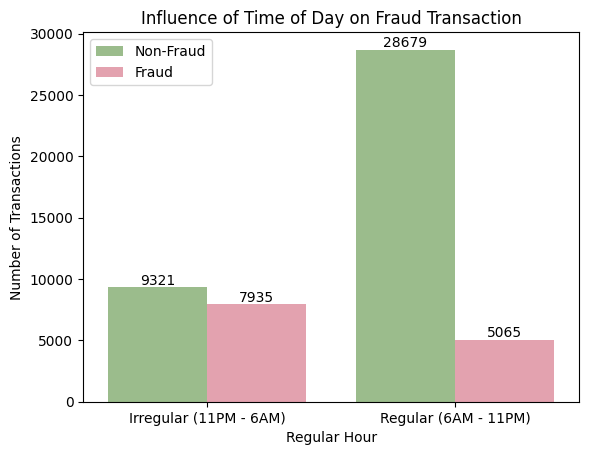

In [ ]:
# Generate a grouped bar plot counting fraud occurrences in regular and irregular hours
ax = sns.countplot(fraud_data, x='is_regular_hour', hue='is_fraud', palette=['#338A0B', '#DF3053'], alpha=0.5)

# Set labels, title, and legend
ax.set_xlabel("Regular Hour")
ax.set_ylabel("Number of Transactions")
ax.set_title("Influence of Time of Day on Fraud Transaction")
ax.set(xticklabels=["Irregular (11PM - 6AM)", "Regular (6AM - 11PM)"])
ax.legend(title='', labels=['Non-Fraud', 'Fraud'])
for l in ax.containers:
 ax.bar_label(l)

Takeaway:

*   We can see a big difference in the ratio of fraudulent transactions to all transactions during irregular and regular hours by simply looking at the graph. Through computation we discover 45.98% of transactions occurring during irregular hours are fraudulent, compared with a percentage of only 15.01% during regular hours. The result concludes that transactions are much more likely to be fraudulent during irregular hours than during regular hours, which aligns with our proposition.



## 3.2 Relationship Between Transaction Amount and Fraudulent Transaction

Having explored how the day of time influences the possibility that a transaction is fraudulent, we shift our focus to the factor of transcaction amount. This corresponds to the `purchase_amount` column, and let's take a first look about its descriptive statistics such as distribution and range.

In [ ]:
fraud_data['purchase_amount'].describe()

count    51000.000000
mean       184.948451
std        304.577089
min          1.000000
25%         14.777500
50%         60.200000
75%        151.802500
max       7886.260000
Name: purchase_amount, dtype: float64

To better understand the effectiveness of transaction amount as an indicator of fraudulent transaction, we can compute the same statistics for each of fraudulent and non-fraudulent transactions.

In [ ]:
fraud_data[['is_fraud', 'purchase_amount']].groupby('is_fraud').describe()

purchase_amount                                                \
                   count        mean         std   min     25%     50%   
is_fraud                                                                 
0                38000.0   66.541749  132.424887  1.00    9.55   46.75   
1                13000.0  531.060351  389.747679  1.06  245.73  394.49   

                             
               75%      max  
is_fraud                     
0          81.7700  7886.26  
1         901.6225  1376.04

Takeaway:

*   This data provides some intuition that there is a non-trivial correlation between the transaction amount and whether the transaction is fraudulent or not. Specifically, fraudulent transactions have a much higher average transaction amount than non-fraudulent ones. By comparing it with the descriptive statistics, the average transaction amount for non-fraudulent transactions (66.54) lies below the mean (184.95) and little above the median (60.20), while that for fraudulent transactions (531.06) lies far above the upper quartile (151.80).

For a better insight into the interquartile range and potential outliers, we employ a a box and whisker plot below. Log scale is used for a clearer visualization since the outlier values are huge.

<ipython-input-22-f78574e65bc9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="is_fraud", y="purchase_amount", data=fraud_data, palette='pastel')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

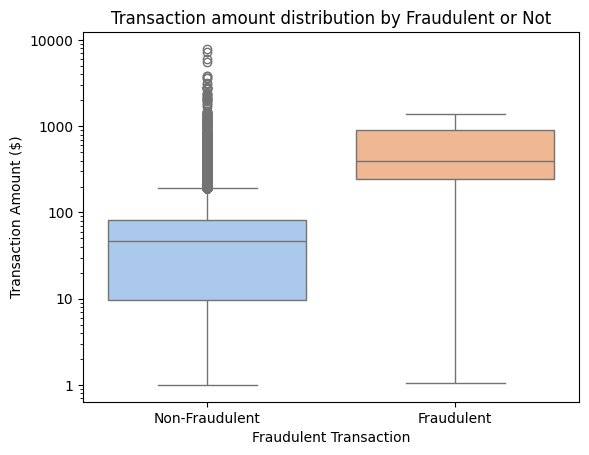

In [ ]:
# Create a box and whisker plot grouped by borough
ax = sns.boxplot(x="is_fraud", y="purchase_amount", data=fraud_data, palette='pastel')

# Set the plot title and axis labels
ax.set_title("Transaction amount distribution by Fraudulent or Not")
ax.set_xlabel("Fraudulent Transaction")
ax.set_ylabel("Transaction Amount ($)")
ax.set(xticklabels=["Non-Fraudulent", "Fraudulent"])
ax.set_yscale("log")

# Set the y-axis ticks (log-scale)
ticks = [1, 10, 100, 1000, 10000]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)

# Show the plot
plt.show()

Takeaway:


*   One thing to note from the box plot is there are no outliers for transaction amount in fraudulent transactions, but many for non-fraudulent transactions. This might be attributed to the fact that the data points for non-fraudulent transactions are approximately three-fold, leading to more extreme values, but also suggests fraudulent transactions has a more predictable patterns in the amount of transaction.

Now that we have gained an overview of the distribution of the transaction amount data, we want to take a look at how fraudulent and non-fraudulent transaction amount are scattered across different ranges. Histograms are therefore employed to achieve this.

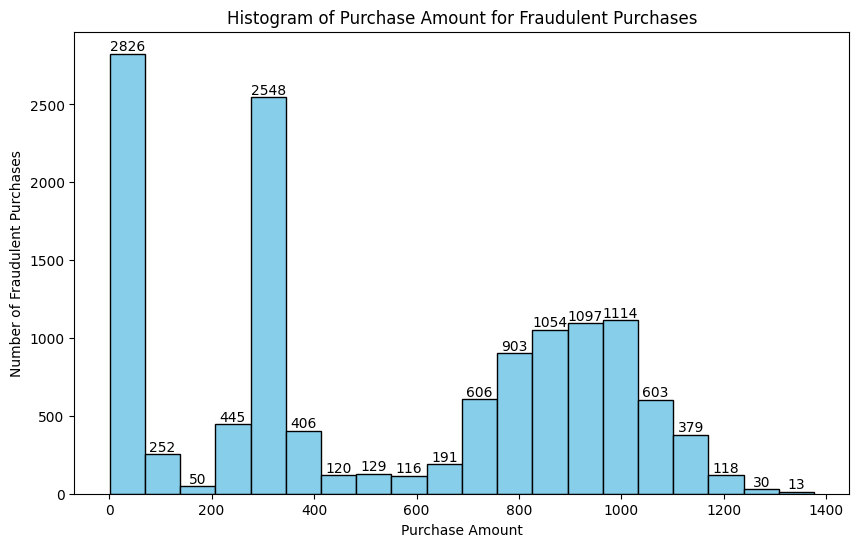

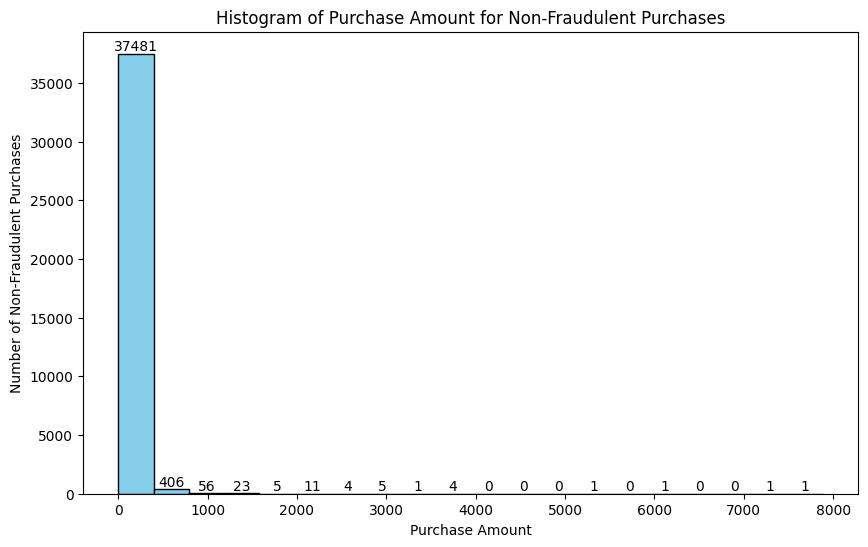

In [ ]:
# 1. Histogram for fraudulent transactions

# Get all fraud entries
fraudulent_df = fraud_data[fraud_data['is_fraud'] == 1]

# Generate a histogram with 20 bins of purchase amount range
plt.figure(figsize=(10, 6))
counts, edges, bars = plt.hist(fraudulent_df['purchase_amount'], bins=20, color='skyblue', edgecolor='black')
plt.bar_label(bars)

# Add labels and title
plt.xlabel('Purchase Amount')
plt.ylabel('Number of Fraudulent Purchases')
plt.title('Histogram of Purchase Amount for Fraudulent Purchases')

plt.show()


# 2. Histogram for non-fraudulent transactions

# Get all non-fraud entries
non_fraudulent_df = fraud_data[fraud_data['is_fraud'] == 0]

# Generate a histogram with 20 bins of purchase amount range
plt.figure(figsize=(10, 6))
counts, edges, bars = plt.hist(non_fraudulent_df['purchase_amount'], bins=20, color='skyblue', edgecolor='black')
plt.bar_label(bars)

# Add labels and title
plt.xlabel('Purchase Amount')
plt.ylabel('Number of Non-Fraudulent Purchases')
plt.title('Histogram of Purchase Amount for Non-Fraudulent Purchases')

plt.show()

Takeaway:

*   As we can see here, the histogram for fraudulent purchases has three main spikes of data. This means that if we train our model using this feature (purchase amount) then it will more likely categorize a purchase within these purchase zones as fraud.

## 3.3 Fraudulence by Transaction Type

It would also allow us to gain a better understanding of fraudulent transactions by looking at in which transaction type fraudulent transactions typically gathers. Here we have two bar plots that show the fraudulent transaction frequency and rate by transaction type, respectively. It would be natural to use bar plots since each category of transaction is associated with a fraudulent frequency and rate and it allows easier comparison among these types. We order the bars for a more intuitive understanding of how that might have a correlation with fraudulent rate.

This is vital to understanding our data as it shows us a more clear depiction of fraud-frequency within different purchase categories. A higher ratio means that the probability that a purchase was fraud, given a certain purchase category, is higher.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
<ipython-input-24-34f79c31cc39>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='fraud_ratio', y=fraud_counts.index, data=fraud_counts, palette=['#338A0B'], alpha=0.5)
<ipython-input-24-34f79c31cc39>:29: UserWarning: 
The palett

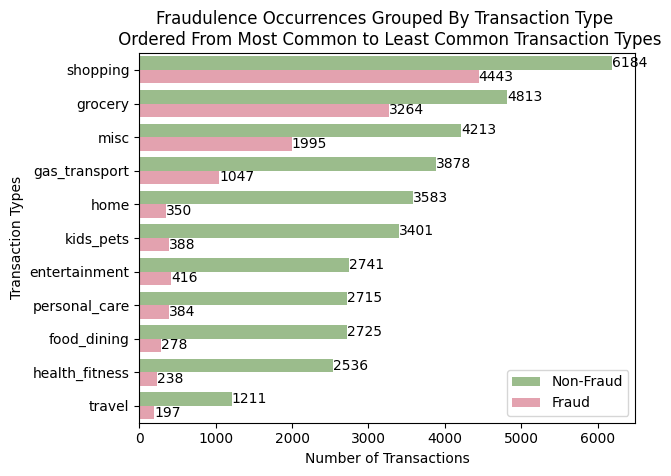

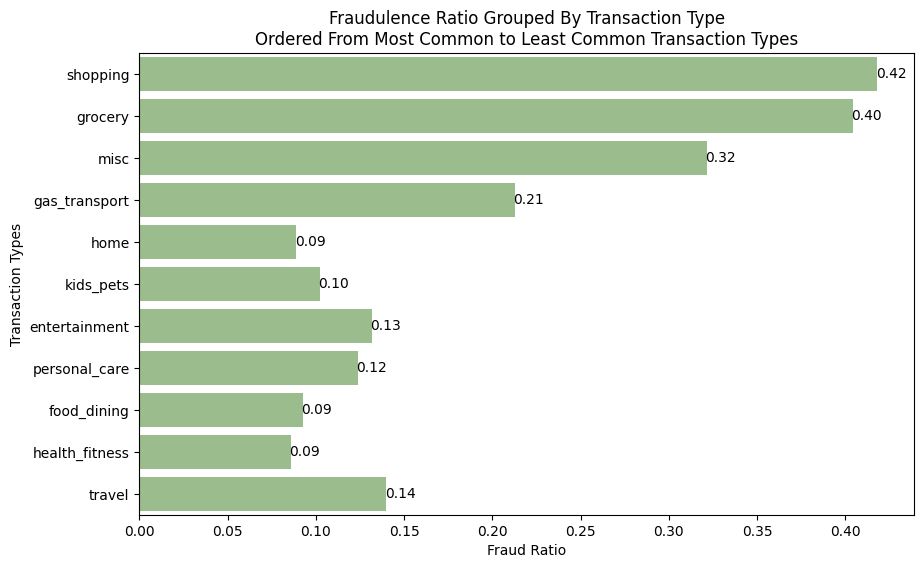

In [ ]:
## 1: Fraud Frequency vs. type

# Generate a count plot
ax = sns.countplot(data=fraud_data, y='purchase_type', hue='is_fraud', order=fraud_data['purchase_type'].value_counts().index, palette=['#338A0B', '#DF3053'], alpha=0.5)

# Add labels, title, and legend
ax.set_xlabel("Number of Transactions")
ax.set_ylabel("Transaction Types")
ax.set_title("Fraudulence Occurrences Grouped By Transaction Type \n Ordered From Most Common to Least Common Transaction Types")
ax.legend(title='', labels=['Non-Fraud', 'Fraud'])
for l in ax.containers:
 ax.bar_label(l)


## 2: Fraud Ratio vs. type

# Calculate the counts of Fraud and Non-Fraud purchases for each purchase type
fraud_counts = fraud_data.groupby(['purchase_type', 'is_fraud']).size().unstack(fill_value=0)
fraud_counts['total'] = fraud_counts.sum(axis=1)

# Calculate the fraud ratio for each purchase type
fraud_counts['fraud_ratio'] = fraud_counts[1] / fraud_counts['total']

# Sort the DataFrame by total transactions in descending order
fraud_counts = fraud_counts.sort_values(by='total', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='fraud_ratio', y=fraud_counts.index, data=fraud_counts, palette=['#338A0B'], alpha=0.5)
ax.set_xlabel("Fraud Ratio")
ax.set_ylabel("Transaction Types")
ax.set_title("Fraudulence Ratio Grouped By Transaction Type\nOrdered From Most Common to Least Common Transaction Types")

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.2f'),
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha = 'center', va = 'center',
                xytext = (10, 0),
                textcoords = 'offset points')

plt.show()

Takeaway:


*   From the visualizations, the top three transaction types having high fraudulent transaction rate are "shopping" (42%), "grocery" (40%), and "misc" (32%). One thing noteworthy here is that these three categories are also the top 3 common transaction types. We suppose the reason for the high correlation between frequency and fraudulent rate of transaction types is that common transaction types make fraudulent activities easier to go unnoticed by credit card holders.  





## 3.4 Exploring Transaction Frequency

After exploring different factors that might have an influence on fraudulency including time of day, transaction amount, and transaction type, we want to take a look at a fourth potential factor: transaction frequency within a short time frame (here we define as 4 hours). Therefore, we create a new feature in our data frame named `transaction_count_last_four_hours` which is an integer associated with each transaction that tells us how many transactions have occurred for the associated credit card number within the last 4 hours, excluding this one.



In [ ]:
# Compute the number of transactions in the last four hours for the same card
for idx, row in fraud_data.iterrows():
  card_num = row['card_number']
  txn_time = row['transaction_datetime']
  temp = fraud_data[fraud_data['card_number'] == card_num]
  # Get the number of transactions for the same card within the last four hours
  count = len(temp[((txn_time - temp['transaction_datetime']) > timedelta(hours=0)) & ((txn_time - temp['transaction_datetime']) < timedelta(hours=4))])
  fraud_data.at[idx, 'transaction_count_last_four_hours'] = count

fraud_data.head()

,transaction_datetime,purchase_type,purchase_amount,buyer_gender,card_number,buyer_age,store_long,store_lat,is_fraud,is_regular_hour,transaction_count_last_four_hours
0,2019-06-02 12:02:15,food_dining,19.33,F,6528911529051375,54,-90.584866,46.627470,0,1,0.0
1,2019-04-02 17:26:36,home,39.96,F,4561368699336875,30,-80.878043,35.866491,0,1,0.0
2,2020-07-24 07:20:24,grocery,135.58,F,60490596305,57,-90.632878,34.316550,0,1,0.0
3,2020-08-30 23:26:50,shopping,8.05,M,4312133045694601139,43,-76.537518,38.601080,0,0,0.0
4,2020-07-16 20:40:10,kids_pets,12.93,F,4129767952109660,48,-95.906156,47.010306,0,1,0.0


Having generated the new feature, we want to have a general understanding of its distribution through its descriptive statistics and a histogram that provides a count for each transaction frequency.

In [ ]:
fraud_data['transaction_count_last_four_hours'].describe()

count    51000.000000
mean         0.509353
std          1.536152
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.000000
Name: transaction_count_last_four_hours, dtype: float64

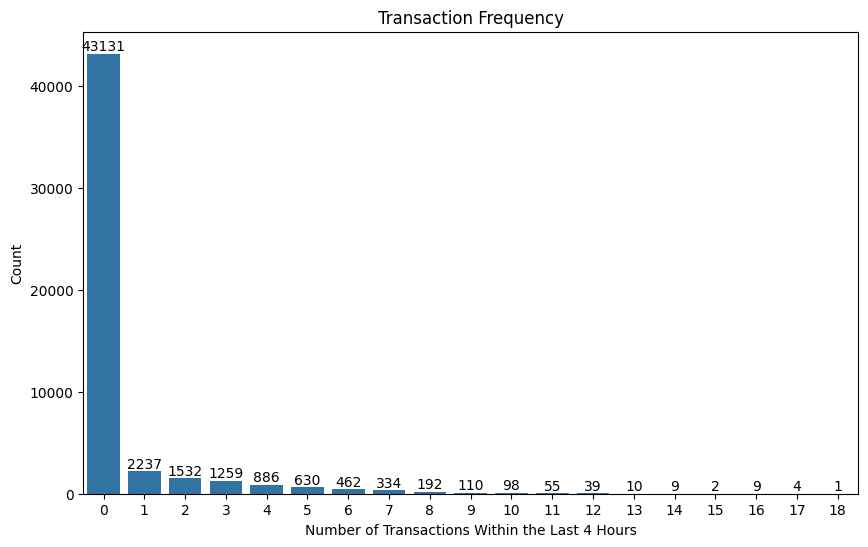

In [ ]:
# Make a count plot for each number of transactions
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=fraud_data, x='transaction_count_last_four_hours')

# Set labels and title
ax.set_xlabel("Number of Transactions Within the Last 4 Hours")
ax.set_ylabel("Count")
ax.set_title("Transaction Frequency")
for l in ax.containers:
 ax.bar_label(l)

# Set x-ticks with integer values
ax.set_xticks(np.arange(19))
xlabels = ['{:,.0f}'.format(x) for x in ax.get_xticks()]
ax.set_xticklabels(xlabels);

Takeaway:
*   Based on the dataset, the average transaction count for a given credit card number within the last 4 hours is about 0.51, a pretty low number. Nearly 84.6% (43131 out of 51000) of all the transactions have no transactions within that time frame excluding the current one. But there also exists extreme points that go as high as to 18 transactions within the last four hours.



One intriguing question to ask is: does transaction frequency defined above have a correlataion with fraudulent rate? To explore this question further, we compute the fraudulent rate for each frequency category (through computing two DataFrame's that contain the fraudulent and total count for each and joining them) and draw a line plot because both features are numerical and allows us to have a deeper insight into how the fraudulent rate changes in response to increase in transaction frequency.

In [ ]:
# Fraud count for each category
fraud_count = fraud_data.groupby('transaction_count_last_four_hours')['is_fraud'].sum().reset_index().rename(columns={'is_fraud': 'fraud_count'})

# Total count for each category
total_count = fraud_data.groupby('transaction_count_last_four_hours')['is_fraud'].count().reset_index().rename(columns={'is_fraud': 'total_count'})

# Joining the two tables
transaction_freq_with_fraud_rate = fraud_count.merge(total_count, on='transaction_count_last_four_hours')

# Compute fraud rate (fraud count / total count) for each category
transaction_freq_with_fraud_rate['fraud_rate'] = transaction_freq_with_fraud_rate['fraud_count'] / transaction_freq_with_fraud_rate['total_count']
transaction_freq_with_fraud_rate

,transaction_count_last_four_hours,fraud_count,total_count,fraud_rate
0,0.0,5677,43131,0.131622
1,1.0,1707,2237,0.763076
2,2.0,1519,1532,0.991514
3,3.0,1257,1259,0.998411
4,4.0,885,886,0.998871
5,5.0,630,630,1.000000
6,6.0,462,462,1.000000
7,7.0,334,334,1.000000
8,8.0,192,192,1.000000
9,9.0,110,110,1.000000


Text(0.5, 1.0, 'Correlation between Transaction Frequency \n and Fraudulent Rate')

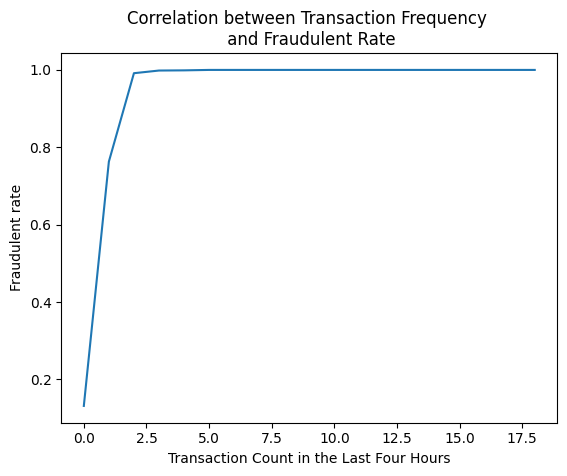

In [ ]:
# Create a line plot
ax5 = sns.lineplot(data=transaction_freq_with_fraud_rate, x='transaction_count_last_four_hours', y='fraud_rate')

# Set labels and title
ax5.set_xlabel("Transaction Count in the Last Four Hours")
ax5.set_ylabel("Fraudulent rate")
ax5.set_title("Correlation between Transaction Frequency \n and Fraudulent Rate")

Takeaway:

*   From the line plot, there seems to be a direct correlation between transaction frequency and fraudulent rate. One feature of this graph noteworthy is that as soon as the transaction count in the last four hours goes to 5, the fraudulent rate remains 100% for all the higher values.



## 3.5 Exploring Buyer Gender Using Plots

One other factor we are interested in the buyer's gender. As with part 3.3, we made two bar plots which show the fraudulent frequency and rate by buyer gender.

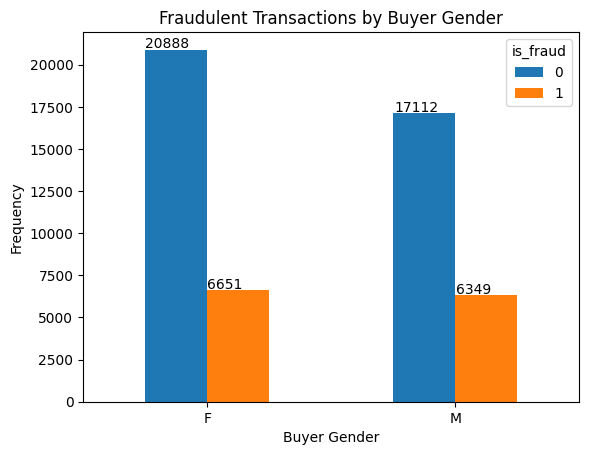

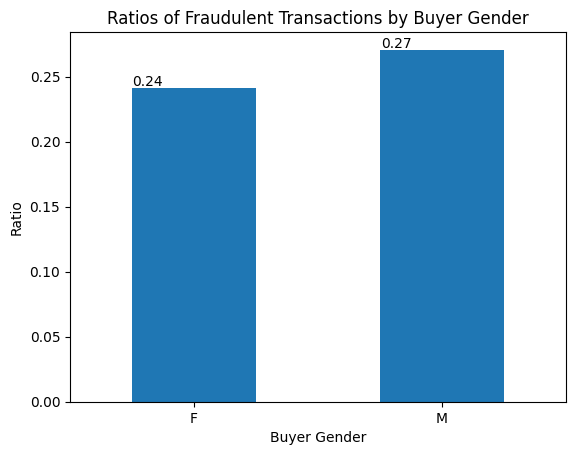

In [ ]:
genderData = fraud_data[['buyer_gender','is_fraud']]

grouped_df = genderData.groupby(['buyer_gender', 'is_fraud']).size().unstack(fill_value=0)

# Plotting the bar graph
ax = grouped_df.plot(kind='bar', stacked=False)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


# Setting labels and title
plt.xlabel('Buyer Gender')
plt.ylabel('Frequency')
plt.title('Fraudulent Transactions by Buyer Gender')
for label in ax.get_xticklabels():
  label.set_rotation(0)


# Calculate the fraud ratio
grouped_df['fraud_ratio'] = grouped_df[1] / (grouped_df[0] + grouped_df[1])

# Plotting the bar graph
ax = grouped_df.plot(kind='bar',y=['fraud_ratio'] ,stacked=False)

# Annotate bars with exact values
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))

# Setting labels and title
plt.xlabel('Buyer Gender')
plt.ylabel('Ratio')
plt.title('Ratios of Fraudulent Transactions by Buyer Gender')
ax.get_legend().remove()
for label in ax.get_xticklabels():
  label.set_rotation(0)

# Show the plot
plt.show()

Takeaway:

*   Although Female recieved more raw fraud purchases, the fraud frequency, relative to the total amount of purchases within a gender, is actually higher within the Male category. Nevertheless, there are no notable differences between these two categories.

# Part 4: Feature Engineering and Preprocessing

## 4.1 Dropping Irrelevant Columns & Encoding Categorical Features

Based on insights gained from our EDA, we turn to conducting an additional layer of data processing by dropping irrelevant columns (this includes what we have discovered during the EDA process and by the nature of the features) and encoding categorical features we think are meaningful in building our machine learning models, for example purchase type. In this section, we will convert these features into numerical values.

First, we have found through EDA that buyer's gender does not contribute much to detection of fraudulent transactions. We drop this column as a result. In addition, we have extracted a useful feature with card number and it seems to not contribute to our fraud detection.

In [ ]:
fraud_data = fraud_data.drop(columns=['buyer_gender', 'card_number', 'Unnamed: 0'], errors='ignore')

Having extracted two features, `is_regular_hour` and `transaction_count_last_four_hours`, from the column `transaction_datetime` and discovered that these might have an influence on the fraudulent rate, we want to further extract year, month, and day into separate numeric columns for our modeling process. With all useful features extracted, the column `transaction_datetime` can now be dropped.



In [ ]:
# Extract transaction year, month, and day
fraud_data['transaction_year'] = fraud_data['transaction_datetime'].dt.year
fraud_data['transaction_month'] = fraud_data['transaction_datetime'].dt.month
fraud_data['transaction_day'] = fraud_data['transaction_datetime'].dt.day
fraud_data = fraud_data.drop(columns=['transaction_datetime'])

Lastly, recognizing that we need the `purchase_type` column in numerical term for our model, we employed One Hot Encoding to this last categorical feature.

In [ ]:
# One-hot encode purchase type, a column with categorical values
dummy_df = pd.get_dummies(fraud_data['purchase_type'], dtype='int')
fraud_data = pd.concat([fraud_data, dummy_df], axis = 1)
fraud_data = fraud_data.drop(columns=['purchase_type'])
fraud_data

,purchase_amount,buyer_age,store_long,store_lat,is_fraud,is_regular_hour,transaction_count_last_four_hours,transaction_year,transaction_month,transaction_day,...,food_dining,gas_transport,grocery,health_fitness,home,kids_pets,misc,personal_care,shopping,travel
0,19.33,54,-90.584866,46.627470,0,1,0.0,2019,6,2,...,1,0,0,0,0,0,0,0,0,0
1,39.96,30,-80.878043,35.866491,0,1,0.0,2019,4,2,...,0,0,0,0,1,0,0,0,0,0
2,135.58,57,-90.632878,34.316550,0,1,0.0,2020,7,24,...,0,0,1,0,0,0,0,0,0,0
3,8.05,43,-76.537518,38.601080,0,0,0.0,2020,8,30,...,0,0,0,0,0,0,0,0,1,0
4,12.93,48,-95.906156,47.010306,0,1,0.0,2020,7,16,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50995,6.42,29,-109.662565,40.192029,0,1,0.0,2019,6,29,...,0,0,0,0,0,0,0,0,1,0
50996,44.56,47,-123.078309,39.363882,0,1,0.0,2020,4,28,...,1,0,0,0,0,0,0,0,0,0
50997,37.93,41,-91.433812,30.557085,0,0,0.0,2019,11,16,...,0,0,1,0,0,0,0,0,0,0
50998,27.82,36,-81.995784,36.213736,0,1,0.0,2020,8,24,...,0,0,0,0,0,0,0,0,0,0


## 4.2 Creating Region Feature Using Clustering

We are given the latitude and longitude of the purchase site, but it would be more useful to group those into regions to analyze fraud behavior in certain regions more generally. We use KMeans to create these clusters.

In [ ]:
# Create KMeans model
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters = 4, random_state = seed)
cluster.fit(fraud_data[["store_long", "store_lat"]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=123)

In [ ]:
# Add a column with the new clusters:
mapping = {0:'Mountain', 1:'Northeast', 2:'West', 3:"Central-South"}
labels = [mapping[i] for i in cluster.labels_]
fraud_data['region_cluster'] = labels

Text(0.5, 1.0, 'Regions of Purchases')

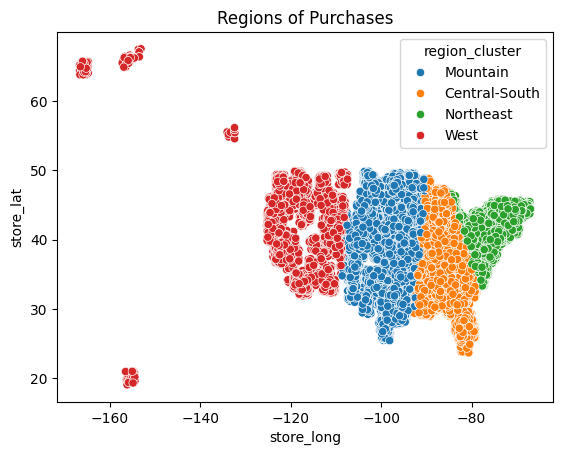

In [ ]:
# Plot new clusters
sns.scatterplot(x = fraud_data.store_long, y = fraud_data.store_lat, hue = fraud_data.region_cluster).set_title("Regions of Purchases")

We can now delete the store_lat and store_long features.

In [ ]:
fraud_data = fraud_data.drop(columns=['store_lat', 'store_long'], errors='ignore')

Now, we one-hot encode the region_cluster column.

In [ ]:
# One-hot encode purchase type, a column with categorical values
dummies = pd.get_dummies(fraud_data['region_cluster'], dtype='int')
fraud_data = pd.concat([fraud_data, dummies], axis = 1)
fraud_data = fraud_data.drop(columns=['region_cluster'])
fraud_data

,purchase_amount,buyer_age,is_fraud,is_regular_hour,transaction_count_last_four_hours,transaction_year,transaction_month,transaction_day,entertainment,food_dining,...,home,kids_pets,misc,personal_care,shopping,travel,Central-South,Mountain,Northeast,West
0,19.33,54,0,1,0.0,2019,6,2,0,1,...,0,0,0,0,0,0,0,1,0,0
1,39.96,30,0,1,0.0,2019,4,2,0,0,...,1,0,0,0,0,0,1,0,0,0
2,135.58,57,0,1,0.0,2020,7,24,0,0,...,0,0,0,0,0,0,1,0,0,0
3,8.05,43,0,0,0.0,2020,8,30,0,0,...,0,0,0,0,1,0,0,0,1,0
4,12.93,48,0,1,0.0,2020,7,16,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50995,6.42,29,0,1,0.0,2019,6,29,0,0,...,0,0,0,0,1,0,0,0,0,1
50996,44.56,47,0,1,0.0,2020,4,28,0,1,...,0,0,0,0,0,0,0,0,0,1
50997,37.93,41,0,0,0.0,2019,11,16,0,0,...,0,0,0,0,0,0,1,0,0,0
50998,27.82,36,0,1,0.0,2020,8,24,1,0,...,0,0,0,0,0,0,1,0,0,0


## 4.3 Feature Correlation Heap Map

After all the data cleaning and engineering procecss is done, we want to make sure the final remaining data is as independent as possible. This leads us to plot a feature correlation heap map.

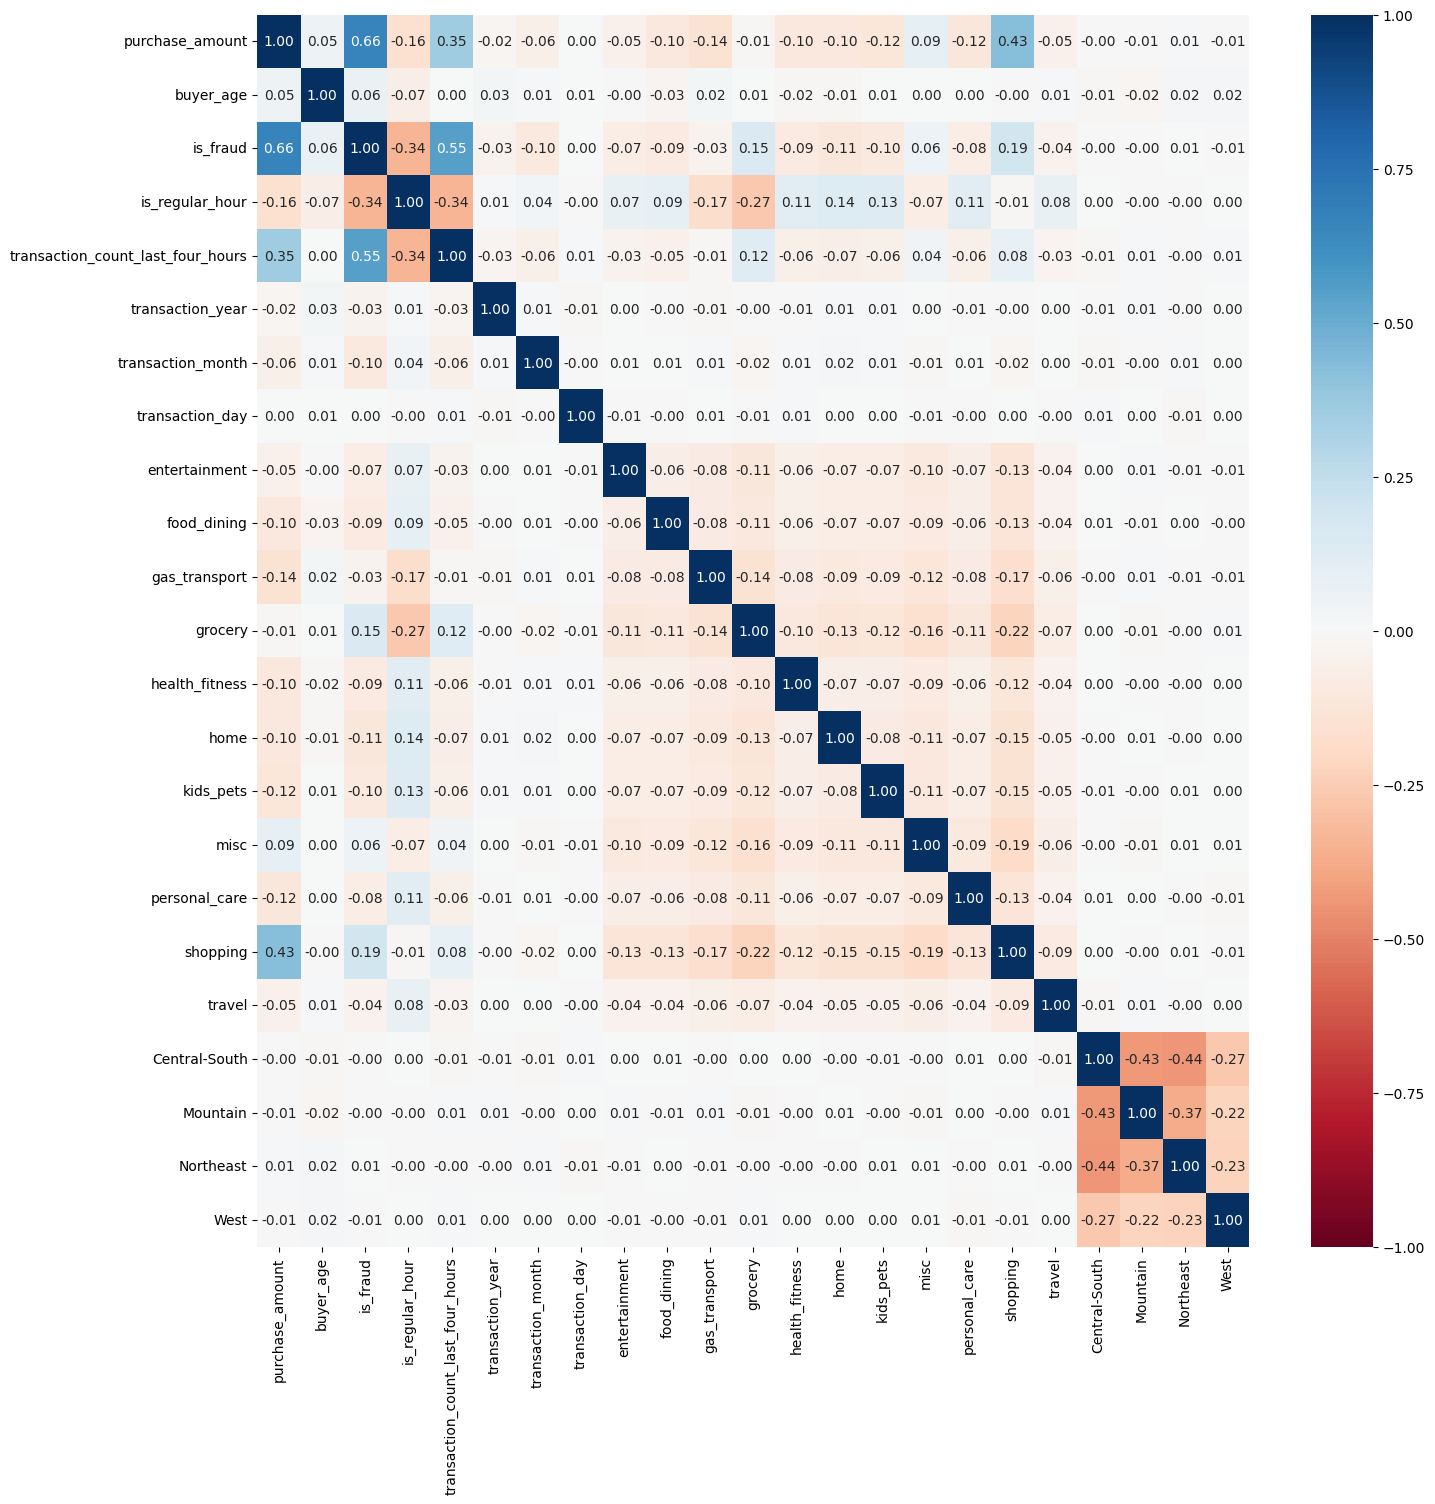

In [ ]:
# Feature correlation heat map
plt.figure(figsize=(16, 16))
fig = sns.heatmap(data = fraud_data.corr(), cmap = 'RdBu', vmin = -1, vmax = 1, annot = True, fmt=".2f")
plt.show()

Takeaways:

*   As we can see from the correlatioin heat map, `purchase_amount` and `is_fraud`, and `transaction_count_last_four_hours` and `is_fraud` are the feature pairs having the strongest correlations. This corresponds to the result exhibited during our EDA.

*   Another thing that draws our attention is that among all purchase types, shopping seems to have a much higher correlation (0.43) with purchase amount than others. This might be due to the fact that shopping has the highest fraudulent rate, which then pulls up purchase amount.



# Part 5: Modeling

## 5.1 Logistic Regression

### 5.1.1 First Attempt: Base Model

We'll first start with a logisitic regression model using `purchase_amount` and `is_regular_hour` as the only features, given they showed to have some sort of distinct relationship with `is_fraud` from the above EDA.

Creating our training and testing splits, and creating our model.

In [ ]:
# Conduct 80/20 train-test split with random_state = seed
X_train, X_test, y_train, y_test = train_test_split(fraud_data[["purchase_amount", "is_regular_hour"]], fraud_data["is_fraud"],
                                                    test_size = 0.2, shuffle = True, stratify = fraud_data["is_fraud"], random_state = seed)

# Instantiate Logistic Regression model
model = LogisticRegression()

Standardizing the purchase_amount feature.

In [ ]:
# Initialize and apply scaler
scaler = StandardScaler()
X_train['purchase_amount'] = scaler.fit_transform(X_train["purchase_amount"].to_numpy().reshape(-1,1))
X_test['purchase_amount'] = scaler.transform(X_test['purchase_amount'].to_numpy().reshape(-1,1))

Fitting the model.

In [ ]:
model.fit(X_train, y_train)

LogisticRegression()

Here is the log odds equation with the model's intercept and coefficients.

In [ ]:
print("log odds is_fraud=1\n=", model.intercept_[0].round(3), "+",
      model.coef_[0][0].round(3), "* purchase_amount +",
      model.coef_[0][1].round(3), "* is_regular_hour")

log odds is_fraud=1
= -0.179 + 2.25 * purchase_amount + -1.822 * is_regular_hour


Getting our prediction from the testing data.

In [ ]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [ ]:
C = confusion_matrix(y_test, test_pred)
print("Confusion Matrix for Test Set:")
display(pd.DataFrame(C, index=['actual=0','actual=1'], columns=['pred=0','pred=1']))


Confusion Matrix for Test Set:


,pred=0,pred=1
actual=0,7478,122
actual=1,810,1790


In [ ]:
print("Training Accuracy = ", metrics.accuracy_score(y_train, train_pred).round(4)*100,"%",
      "\nTraining Precision =", metrics.precision_score(y_train, train_pred).round(4)*100,"%",
      "\nTraining Recall = ", metrics.recall_score(y_train, train_pred).round(4)*100,"%",
    "\n\nTesting Accuracy = ", metrics.accuracy_score(y_test, test_pred).round(4)*100,"%",
      "\nTesting Precision =", metrics.precision_score(y_test, test_pred).round(4)*100,"%",
      "\nTesting Recall = ", metrics.recall_score(y_test, test_pred).round(4)*100,"%")

Training Accuracy =  91.05 % 
Training Precision = 92.91 % 
Training Recall =  70.23 % 

Testing Accuracy =  90.86 % 
Testing Precision = 93.62 % 
Testing Recall =  68.85 %


It seems we have achieved pretty good accuracy and precision with just the two features. It might also take some work for the low recall. The metrics show us the model is great at avoiding non-fraud transactions, but not too good at identifying fraud transactions.

### 5.1.2 Adding Features with Regularization Attempt

Attempting to increase the recall rate, we now want to incorporate the full set of features to see how our model performs.

In [ ]:
# With full features, conduct 80/20 train-test split with random_state = seed
X_train, X_test, y_train, y_test = train_test_split(fraud_data.drop('is_fraud', axis = 1), fraud_data['is_fraud'],
                                                    test_size = 0.2, shuffle = True, stratify = fraud_data['is_fraud'], random_state = seed)

# Initializing scaler
scaler = StandardScaler()

# Fitting and transforming on the training and testing set
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate Logistic Regression model
model = LogisticRegression()

# Fit and predict on training and testing data
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [ ]:
# Compute performance metrics for both models
train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)
train_rec = recall_score(y_train, train_pred)
test_rec = recall_score(y_test, test_pred)
train_pre = precision_score(y_train, train_pred)
test_pre = precision_score(y_test, test_pred)

print(f'Training Accuracy: {train_acc*100:.2f}%')
print(f'Training Precision: {train_pre*100:.2f}%')
print(f'Training Recall: {train_rec*100:.2f}%\n')

print(f'Testing Accuracy: {test_acc*100:.2f}%')
print(f'Testing Precision: {test_pre*100:.2f}%')
print(f'Testing Recall: {test_rec*100:.2f}%')

Training Accuracy: 94.56%
Training Precision: 95.66%
Training Recall: 82.38%

Testing Accuracy: 94.63%
Testing Precision: 95.72%
Testing Recall: 82.62%


With more features added, we can clearly see a boost in recall. There are marginal increases in the other two metrics as well. This is what we expect as the model gathers more information for its detection of fraud other than purchase amount (though this could be a significant factor as indicated by the high accuracy with only that feature). Another good thing is training and testing metrics stay roughly the same, which means the model fits the data well. Though no overfitting is shown, we want to see how adding regularization (Lasso, Ridge, and ElasticNet) would affect the model performance.

We want to employ Grid Search and Cross Validation to find the optimum hyperparameter for regularized logistic regression. As hyperparamter tuning is a relatively expensive part of building machine learning model, we decide to parallalize this task through the usage of Spark. First, let us set up a Spark environment and convert `fraud_data` into a Spark DataFrame.

In [ ]:
spark = SparkSession.builder.appName('final_project').getOrCreate()

In [ ]:
# Convert fraud data into Spark DataFrame
fraud_data_sdf = spark.createDataFrame(fraud_data)

# Convert the data type of is_fraud to double for evaluation of model performance
fraud_data_sdf = fraud_data_sdf.withColumn("is_fraud", fraud_data_sdf.is_fraud.cast("double"))

fraud_data_sdf.show(5)

+---------------+---------+--------+---------------+---------------------------------+----------------+-----------------+---------------+-------------+-----------+-------------+-------+--------------+----+---------+----+-------------+--------+------+-------------+--------+---------+----+
|purchase_amount|buyer_age|is_fraud|is_regular_hour|transaction_count_last_four_hours|transaction_year|transaction_month|transaction_day|entertainment|food_dining|gas_transport|grocery|health_fitness|home|kids_pets|misc|personal_care|shopping|travel|Central-South|Mountain|Northeast|West|
+---------------+---------+--------+---------------+---------------------------------+----------------+-----------------+---------------+-------------+-----------+-------------+-------+--------------+----+---------+----+-------------+--------+------+-------------+--------+---------+----+
|          19.33|       54|     0.0|              1|                              0.0|            2019|                6|            

For Spark ML, we also need to create a concatenated "features" column using VectorAssembler. So let's just do that.

In [ ]:
# Generate a concatenated "features" column using VectorAssembler

feature_columns = [col for col in fraud_data_sdf.columns if col != 'is_fraud']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
pipe = Pipeline(stages = [assembler])
fraud_data_sdf = pipe.fit(fraud_data_sdf).transform(fraud_data_sdf)

fraud_data_sdf.show(5)

+---------------+---------+--------+---------------+---------------------------------+----------------+-----------------+---------------+-------------+-----------+-------------+-------+--------------+----+---------+----+-------------+--------+------+-------------+--------+---------+----+--------------------+
|purchase_amount|buyer_age|is_fraud|is_regular_hour|transaction_count_last_four_hours|transaction_year|transaction_month|transaction_day|entertainment|food_dining|gas_transport|grocery|health_fitness|home|kids_pets|misc|personal_care|shopping|travel|Central-South|Mountain|Northeast|West|            features|
+---------------+---------+--------+---------------+---------------------------------+----------------+-----------------+---------------+-------------+-----------+-------------+-------+--------------+----+---------+----+-------------+--------+------+-------------+--------+---------+----+--------------------+
|          19.33|       54|     0.0|              1|                  

Next, we create the training and test set with a 4:1 ratio.

In [ ]:
# Do a 80/20 train-test split
train_sdf, test_sdf = fraud_data_sdf.randomSplit([0.8, 0.2], seed = seed)

Now, we have the setup complete to add regularization to our Logistic Regression model.

In [ ]:
# Import required libraries
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder

# Instantiate a Logistic Regression model
lr_model_reg = LogisticRegression(featuresCol='features', labelCol='is_fraud')

# Define parameter grid
regParam_values = [0.2, 0.4, 0.6]
elasticNetParam_values = [0.0, 0.5, 1.0]

param_grid = ParamGridBuilder() \
    .addGrid(lr_model_reg.regParam, regParam_values) \
    .addGrid(lr_model_reg.elasticNetParam, elasticNetParam_values) \
    .build()

# Instantiate a BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')

# Create a 3-fold Logistic Regression Cross Validator and fit the training data
cv = CrossValidator(estimator=lr_model_reg, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
cvModel = cv.fit(train_sdf)

Now that the Grid Search has completed, we want to get the best model and use it to calculate the metrics.

In [ ]:
# Save the best model
best_rf_model = cvModel.bestModel

# Training accuracy
training_accuracy_rf = best_rf_model.summary.accuracy

# Testing accuracy
predictions = best_rf_model.transform(test_sdf)
predictionAndLabels = predictions.select('prediction', 'is_fraud').rdd
metrics = MulticlassMetrics(predictionAndLabels)
test_accuracy_rf = metrics.accuracy

confusion_matrix_rf = metrics.confusionMatrix()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
print("Training Accuracy =", round(training_accuracy_rf, 3)*100,"%",
      "\nTesting Accuracy =", round(test_accuracy_rf, 4)*100,"%")

Training Accuracy = 88.5 % 
Testing Accuracy = 87.83 %


In [ ]:
print("Testing precision =", round(metrics.precision(1.0), 4)*100,"%",
      "\nTesting recall =", round(metrics.recall(1.0), 4)*100,"%")

Testing precision = 98.03 % 
Testing recall = 53.36 %


As we can see from the results, testing precision increases to 98% with regularization added, while both the accuracy and recall drop. This occurs as we try to generalize a non-overfitting model with regularization, making the model fit less well.

## 5.2 Random Forest with Grid Search


In addition to Logistic Regression model, we would like to train a Random Forest model as such ensemble method works well with classification problems and can better capture nonlinear relationships than Logistic Regression.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=seed)

# Train the model
rf = rf.fit(X_train, y_train)

# Make predictions
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

In [ ]:
# Evaluate the model

print("Training Accuracy = ", accuracy_score(y_train, y_pred_train).round(4)*100,"%",
      "\nTraining Precision =", precision_score(y_train, y_pred_train).round(4)*100,"%",
      "\nTraining Recall = ", recall_score(y_train, y_pred_train).round(4)*100,"%")
print("\nTesting Accuracy = ", accuracy_score(y_test, y_pred_test).round(4)*100,"%",
      "\nTesting Precision =", precision_score(y_test, y_pred_test).round(4)*100,"%",
      "\nTesting Recall = ", recall_score(y_test, y_pred_test).round(3)*100,"%")

Training Accuracy =  96.44 % 
Training Precision = 98.21 % 
Training Recall =  87.64 %

Testing Accuracy =  96.44 % 
Testing Precision = 98.19 % 
Testing Recall =  87.7 %


We have achieved a really high accuracy of predicting fraudulent transactions using a Random Forest model, which is better than our previous Logistic Regression model trained. The close alignment of training and testing metrics suggests that the model is performing ideally - without overfitting or underfitting. Since we have chosen arbitrary values for a set of hyperparameters for our initial model, we realize that there could be improvement in accuracy through optimizing these hyperparameters. We thus employ Grid Search and Cross Validation for hyperparameter tuning. Similarly, we use Spark for parallalization of this task.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Build a RandomForestClassifier
rf = RandomForestClassifier(featuresCol='features', labelCol='is_fraud', seed=seed)

# Define parameter values for the search of the best combination
max_depth_values = [2, 5, 8, 11, 14]
num_trees_values = [10, 20, 50, 100, 200]

param_grid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, max_depth_values) \
    .addGrid(rf.numTrees, num_trees_values) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')

# Create a 3-fold Logistic Regression Cross Validator and fit the training data
cv = CrossValidator(estimator=rf, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
cvModel = cv.fit(train_sdf)

# Save the best model
best_rf_model = cvModel.bestModel

# Training accuracy
training_accuracy_rf = best_rf_model.summary.accuracy

# Testing accuracy
predictions = best_rf_model.transform(test_sdf)
predictionAndLabels = predictions.select('prediction', 'is_fraud').rdd
metrics = MulticlassMetrics(predictionAndLabels)
test_accuracy_rf = metrics.accuracy

confusion_matrix_rf = metrics.confusionMatrix().toArray()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
print("Best Max Depth:", best_rf_model._java_obj.getMaxDepth(),
      "\nBest Num Trees:", best_rf_model._java_obj.getNumTrees())

Best Max Depth: 14 
Best Num Trees: 200


In [ ]:
print("Confusion Matrix for Test Set:")
display(pd.DataFrame(confusion_matrix_rf, index=['actual=0','actual=1'], columns=['pred=0','pred=1']))

Confusion Matrix for Test Set:


,pred=0,pred=1
actual=0,7548.0,61.0
actual=1,197.0,2408.0


In [ ]:
print("Training Accuracy =", round(training_accuracy_rf, 3)*100,"%",
      "\nTesting Accuracy =", round(test_accuracy_rf, 3)*100,"%")

Training Accuracy = 97.8 % 
Testing Accuracy = 97.5 %


In [ ]:
print("Testing precision =", round(metrics.precision(1.0), 3)*100,"%",
      "\nTesting recall =", round(metrics.recall(1.0), 4)*100,"%")

Testing precision = 97.5 % 
Testing recall = 92.44 %


The metrics above show that we did achieve an even higher accuracy and recall (with a minor drop of < 1% in precision) with the best model parameters obtained by hyperparameter tuning (maximum depth = 14, number of trees = 200). The next thing we want to do is to analyze feature importance. We do this by creating a bar plot as it lets us easily compare the importance of each feature to whether a transaction is fraudulent.

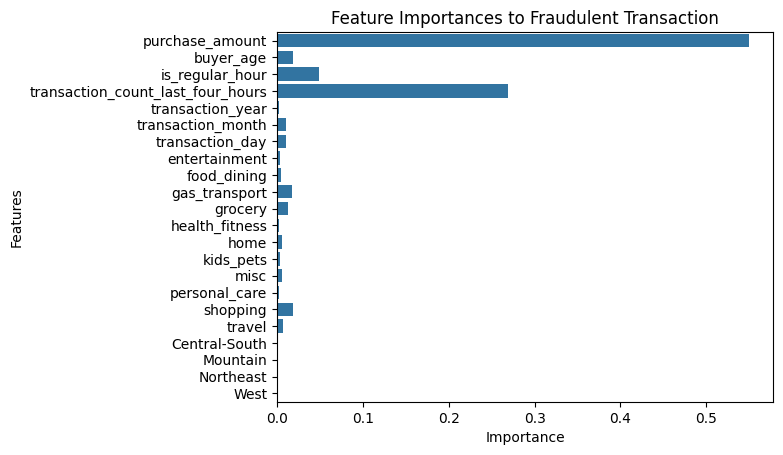

In [ ]:
# Get feature importances and create a bar chart
featureImportances = best_rf_model.featureImportances
sns.barplot(x=featureImportances.toArray(), y=feature_columns).set(title='Feature Importances to Fraudulent Transaction', xlabel='Importance', ylabel='Features');

Takeaway:

*   From the chart, purchase amount and transaction count in the last four hours together account for more than 80 percent of importance to to fraudulent transactions. The result corroborates what we have discovered in our EDA. One aspect of this graph to our surprise is that whether the transaction happens in regular hour does not score as high in feature importance to fraudulent transaction as we seem to find through EDA.

## 5.3 Gradient Boosting Classifier

In addition to the Random Forest model, which has achieved high metrics, we want to implement a Gradient Boosting Classifier, an ensemble method similar to Random Forest that is also based on decision trees. The difference is that Gradient Boosting Classifier trains decision trees sequentially, each correcting the errors of the previous ones, while Random Forest builds the trees independently. We thus predict that Gradient Boostnig Classifier will perform better than Random Forest.

In [ ]:
# Instantiate a GradientBoostingClassifier model
gbc = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 5, random_state = seed)

# Fit a model
gbc = gbc.fit(X_train, y_train)

# Make predictions for the training/testing set
y_pred_train_gbc = gbc.predict(X_train)
y_pred_test_gbc = gbc.predict(X_test)

In [ ]:
# Evaluate the model

print("Training Accuracy = ", accuracy_score(y_train, y_pred_train_gbc).round(3)*100,"%",
      "\nTraining Precision =", precision_score(y_train, y_pred_train_gbc).round(3)*100,"%",
      "\nTraining Recall = ", recall_score(y_train, y_pred_train_gbc).round(3)*100,"%")
print("\nTesting Accuracy = ", accuracy_score(y_test, y_pred_test_gbc).round(4)*100,"%",
      "\nTesting Precision =", precision_score(y_test, y_pred_test_gbc).round(4)*100,"%",
      "\nTesting Recall = ", recall_score(y_test, y_pred_test_gbc).round(4)*100,"%")

Training Accuracy =  98.0 % 
Training Precision = 94.69999999999999 % 
Training Recall =  97.5 %

Testing Accuracy =  96.82 % 
Testing Precision = 92.17999999999999 % 
Testing Recall =  95.65 %


With our initial parameters, the model seems to have a small drop in precision, but higher accuracy and recall compared to the Random Forest model. Though the result is overall the best so far, we still want to see if there is room for improvement by similarly tuning the hyperparameters to determine the ideal values for the number of estimators, maximum depth, and learning rate, but this time we try Randomized Search instead of Grid Search.

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.001, 0.01, 0.1, 1]
}

# Create a GradientBoostingClassifier
gbc = GradientBoostingClassifier()

# Instantiate a RandomizedSearchCV object
random_search = RandomizedSearchCV(gbc, param_distributions = param_grid, n_iter = 10, cv = 5, n_jobs = -1, verbose = 2)

# Fit the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
best_params

{'n_estimators': 200, 'max_depth': 9, 'learning_rate': 1}

In [ ]:
# Instantiate a new GradientBoostingClassifier with the ideal parameters found
gbc_best = GradientBoostingClassifier(**best_params)
gbc_best = gbc_best.fit(X_train, y_train)

# Make predictions using the best parameters
y_pred_train_gbc = gbc_best.predict(X_train)
y_pred_test_gbc = gbc_best.predict(X_test)

In [ ]:
# Evaluate the model

print("Training Accuracy = ", accuracy_score(y_train, y_pred_train_gbc).round(4)*100,"%",
      "\nTraining Precision =", precision_score(y_train, y_pred_train_gbc).round(4)*100,"%",
      "\nTraining Recall = ", recall_score(y_train, y_pred_train_gbc).round(4)*100,"%")
print("\nTesting Accuracy = ", accuracy_score(y_test, y_pred_test_gbc).round(4)*100,"%",
      "\nTesting Precision =", precision_score(y_test, y_pred_test_gbc).round(4)*100,"%",
      "\nTesting Recall = ", recall_score(y_test, y_pred_test_gbc).round(4)*100,"%")

Training Accuracy =  100.0 % 
Training Precision = 100.0 % 
Training Recall =  100.0 %

Testing Accuracy =  98.67 % 
Testing Precision = 97.49 % 
Testing Recall =  97.27 %


With the better hyperparameters found, the model produces marginally higher accuracy, precision, and recall for both the training and test set. From the result, Gradient Boosting Classifier is the optimal model for this transaction dataset than Random Forest. This is to our expectation since Gradient Boosting Classifier corrects the previously fitted trees' errors while Random Forest does not. This is the case even when the exhaustive Grid Search is not applied to find the best set of parameters.

# Part 6: Conclusion

Summary of our takeaways:

*   According to the Random Forest model we built, the most important features contributing to fraudulent transactions are purchase amount and the frequency of transactions within a short time frame, which account for more than 80% of factor importance.  
*   There are other less significant factors such as whether the transaction happens during normal hours, types of transactions, and buyer age. This mostly corresponds to our hypotheses and insights gained through EDA, except that the factor of whether the transaction happens in normal hours seems to have less effect on fraud according to feature importance given by our Random Forest model than as we have seen through EDA.

*   Ensemble models such as Random Forest and Gradient Boosting Classifier perform better for our dataset than Logistic Regression due to the relatively complex relationship of the features, with hyperparameter tuning boosting the performance marginally compared with the initial parameters set. Among the three models used, the Gradient Boosting Classifier model achieves the best accuracy (98.6%), precision (97.0%), and recall (97.3%) in detecting fraudulent transactions.

Future work:

* Some variables we brought up to be used for EDA and modeling are defined arbitrarily. This includes how we define "normal" hours and the frequency of transactions. For a better understanding of these features, we could redefine the short time frame (i.e., 4 hours currently) within which multiple transactions might happen and experiment with different values to gain insight into which among them is the most indicative of fraudulent transaction. The same could be done to the time range within which we consider normal for a transaction to occur.

*   Experiment with neural networks to see if it helps improve the metrics.

